In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import ConfusionMatrixDisplay
import scikitplot

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23906.jpg
/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23966.jpg
/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23933.jpg
/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23919.jpg
/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23912.jpg
/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23928.jpg
/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23990.jpg
/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23911.jpg
/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23975.jpg
/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23984.jpg
/kaggle/input/endoscopydataset/endoscopy_dataset/CuttingProstate/real4_frame_23900.jpg
/kaggle/input/endoscopydataset/endoscopy_da

# **Importation des librairies**

In [2]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay 
import numpy as np

# Chargement du DataSet

In [3]:
data_dir  = "../input/endoscopydataset/endoscopy_dataset"
classes = os.listdir(data_dir)

# Liste des labels
print(classes)

['CuttingProstate', 'PullingSeminalVesicle', 'BladderNeckDissection', 'MovingDownBladder', 'PullingProstate', 'PullingTissue', 'SuckingBlood', 'BladderAnastomosis']


## Transformations:

On redefini la taille de nos images et on les transforment en Tenseur

In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

# Aperçu de quelques images et labels associés

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: CuttingProstate (Class No: 2)


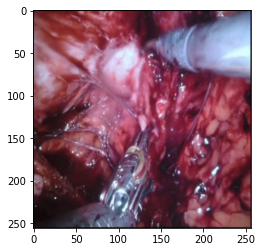

In [6]:
img, label = dataset[300]
show_sample(img, label)

In [7]:
random_seed = 42
torch.manual_seed(random_seed)

# **Division du dataset en train, val et test**

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [454, 195, 163])
len(train_ds), len(val_ds), len(test_ds)

(454, 195, 163)

In [9]:
from torch.utils.data.dataloader import DataLoader
batch_size = 100

### Iterer sur les données et les mélanger de façon aléatoire

In [10]:
#train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Affichage de quelques images

In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

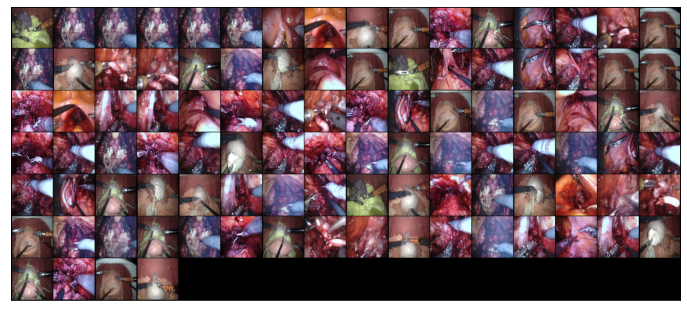

In [12]:
show_batch(train_dl)

# Model

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

Nous utiliserons le Resnet50 pour la classification des images

In [14]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Portage sur GPU:

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

On veut determiner si le host contient un GPU ou pas.
Si oui on travail dessus, sinon on travail sur le CPU

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Entrainement du Model:

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
model = to_device(ResNet(), device)

In [20]:
evaluate(model, val_dl)

{'val_loss': 2.069154739379883, 'val_acc': 0.05128205195069313}

Let's start training the model:

In [21]:
# si model a ete deja entrainer et sauvgarde ---> lire le model
""""if os.path.isfile("./saved_model/model.h5"):

    # lire le model
    model = load_model("./saved_model/model.h5")

    # si l'historique du model a ete sauvgarde --> lire l'historique
    if os.path.isfile("./saved_model/model_history.npy"):

        # lire l'historique
        history = np.load("./saved_model/model_history.npy", allow_pickle="TRUE").item()
    else:
        history = None

# si le model n'a pas ete deja entrainer --> entrainer le model
else:
    num_epochs = 8
    opt_func = torch.optim.Adam
    lr = 5.5e-5 # learning rate

    history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
np.save("./saved_model/model_history.npy", history)
model.save("./saved_model/model.h5")"""

'"if os.path.isfile("./saved_model/model.h5"):\n\n    # lire le model\n    model = load_model("./saved_model/model.h5")\n\n    # si l\'historique du model a ete sauvgarde --> lire l\'historique\n    if os.path.isfile("./saved_model/model_history.npy"):\n\n        # lire l\'historique\n        history = np.load("./saved_model/model_history.npy", allow_pickle="TRUE").item()\n    else:\n        history = None\n\n# si le model n\'a pas ete deja entrainer --> entrainer le model\nelse:\n    num_epochs = 8\n    opt_func = torch.optim.Adam\n    lr = 5.5e-5 # learning rate\n\n    history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)\nnp.save("./saved_model/model_history.npy", history)\nmodel.save("./saved_model/model.h5")'

In [22]:

num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
#np.save("./saved_model/model_history.npy", history)
#model.save("./saved_model/model.h5")

Epoch 1: train_loss: 1.9665, val_loss: 1.9205, val_acc: 0.6205
Epoch 2: train_loss: 1.7339, val_loss: 1.7792, val_acc: 0.8769
Epoch 3: train_loss: 1.6096, val_loss: 1.6521, val_acc: 0.9590
Epoch 4: train_loss: 1.5176, val_loss: 1.5381, val_acc: 0.9744
Epoch 5: train_loss: 1.4491, val_loss: 1.4577, val_acc: 0.9897
Epoch 6: train_loss: 1.3987, val_loss: 1.3966, val_acc: 0.9949
Epoch 7: train_loss: 1.3603, val_loss: 1.3564, val_acc: 1.0000
Epoch 8: train_loss: 1.3374, val_loss: 1.3330, val_acc: 1.0000
Epoch 9: train_loss: 1.3215, val_loss: 1.3188, val_acc: 1.0000
Epoch 10: train_loss: 1.3111, val_loss: 1.3092, val_acc: 1.0000


### Visualisation de l'accuracy

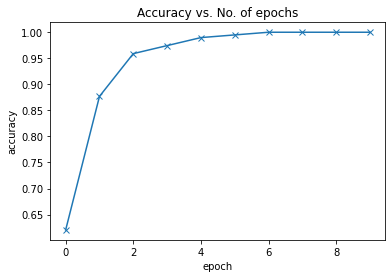

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

### Visualisation du loss

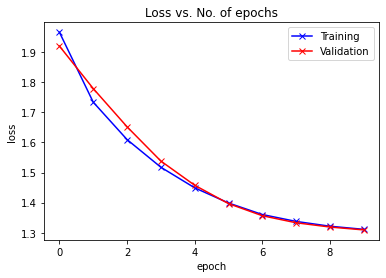

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Visualisation des Predictions:

In [25]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

 **Prediction sur quelques échantillons de test**

Label: SuckingBlood , Predicted: SuckingBlood


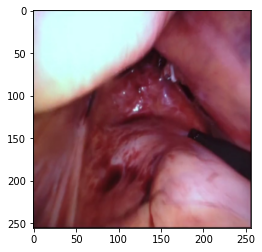

In [26]:
img, label = test_ds[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: BladderNeckDissection , Predicted: BladderNeckDissection


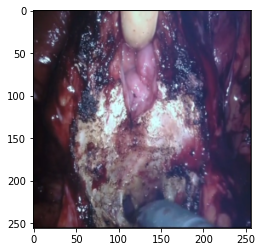

In [27]:
img, label = test_ds[102]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: SuckingBlood , Predicted: SuckingBlood


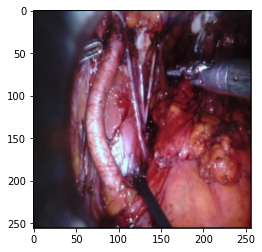

In [28]:
img, label = test_ds[60]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img,model ))

Label: BladderAnastomosis , Predicted: BladderAnastomosis


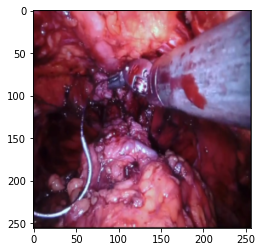

In [29]:
img, label = test_ds[25]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img,model ))

Label: MovingDownBladder , Predicted: MovingDownBladder


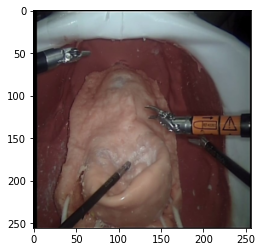

In [30]:
img, label = test_ds[50]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img,model ))

## **Matrice de confusion**

Label: BladderNeckDissection , Predicted: BladderNeckDissection


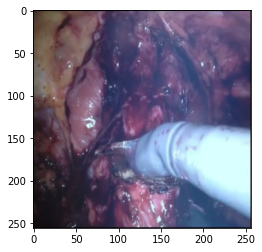

In [31]:
img, label = test_ds[9]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img,model ))

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
taille_test = len(test_ds)
x_test=[]
y_test = []
for i in range(taille_test):
    img, label = test_ds[i]
    x_test.append(img)
    y_test.append(dataset.classes[label])
    



In [33]:
y_pred = []
for i in range(taille_test):
    y_pred.append(predict_image(x_test[i],model))


### Matrice de confusion

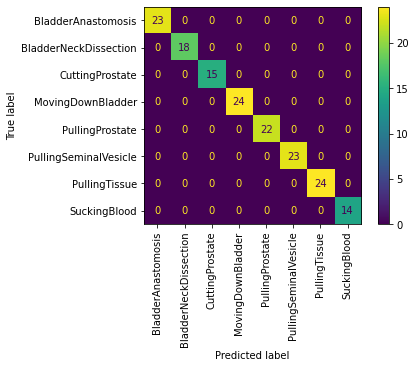

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
import scikitplot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,xticks_rotation="vertical")